In [ ]:
%pip install graphviz

In [375]:
import math

class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # self._prev = set(_children)
        self._prev = _children # maybe don't use set to preserve order
        self._op = _op
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = self._otherify(other)
        return Value(self.data + other.data, (self,other), '+')
    
    def __sub__(self, other):
        return self + -other

    def __neg__(self):
        return -1 * self
    
    def __radd__(self, other):
        return self * other
    
    def __rmul__(self, other):
        return self * other
    
    def __rsub__(self, other):
        return self - other

    def __mul__(self, other):
        other = self._otherify(other)
        return Value(self.data * other.data, (self,other), '*')
    
    def __truediv__(self, other):
        other = self._otherify(other)
        return self * other**Value(-1.0, label='exponent')
    
    def __pow__(self, other):
        other = self._otherify(other)
        x = self.data
        y = other
        return Value(x**other.data, (self, other), 'pow')
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        return Value(t, (self,), 'tanh')
    
    def _otherify(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return other

    # e**x * e**x = e**2x
    def exp(self):
        x = self.data
        return Value(math.exp(x), (self, ), 'exp')
    

    
    # backpropagate through this node and fill out gradients of children
    # depends on the op
    def backward(self, grad):
        self.grad += grad
        if self._op == '+': # in the case of add, you just take the grad of the parent
            x = self._prev[0]
            y = self._prev[1]
            x.backward(grad)
            y.backward(grad)
        elif self._op == '*': # in the case of mul, for node A, set grad to product of all other nodes multipled by grad of the parent
            x = self._prev[0]
            y = self._prev[1]
            x.backward(grad * y.data)
            y.backward(grad * x.data)
        elif self._op == 'tanh': # only dependent on self (input)
            x = self._prev[0]
            t = (math.exp(2*x.data)-1)/(math.exp(2*x.data)+1)
            x.backward(1-t**2 * grad)
        elif self._op == 'exp': # f(x) = e**x; f'(x) = e**x
            x = self._prev[0]
            x.backward(math.exp(x.data) * grad) 
        elif self._op == 'pow': # f(x) = x**y; f'(x) = yx**(y-1)
            x = self._prev[0]
            y = self._prev[1] # exponent
            x.backward(y.data * math.pow(x.data, y.data-1) * grad) 
        else:
            # don't differentiate
            return

a = Value(2.0, label='a')   
b = Value(-3.0, label='b')
c = Value(10.0, label='c') 
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

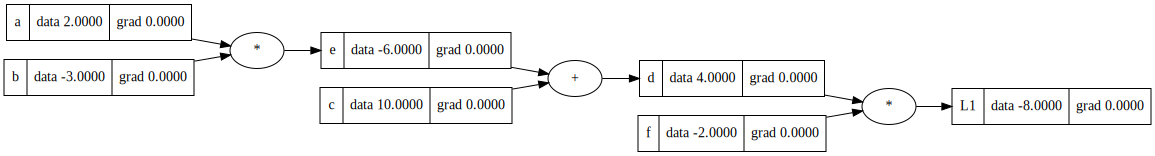

In [36]:
# add visualization to graph
import graphviz

def trace(root):
    nodes = set()
    edges = set()
    def _trace(node):
        if node not in nodes:
            nodes.add(node)
            for child in node._prev:
                edges.add((child, node))
                _trace(child)
    _trace(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = graphviz.Digraph(format="svg", graph_attr={"rankdir":"LR"})
    for node in nodes:
        uid = str(id(node))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (node.label, node.data, node.grad), shape="record")
        if node._op:
            dot.node(name=uid + node._op, label=node._op)
            dot.edge(uid + node._op, uid)
    for src, dst in edges:
        dot.edge(str(id(src)), str(id(dst)) + dst._op)
    return dot

draw_dot(L)

Backpropagation

1) create a variable in Value class that contains derivative with respect to that value (self.grad = 0), grad = 0 means changing this variable does not change the loss function. Grad represents derivative with respect to the variable

Derivative of L with respect to L (i.e. you change by a tiny amount h, it changes by h. So derivative is 1)



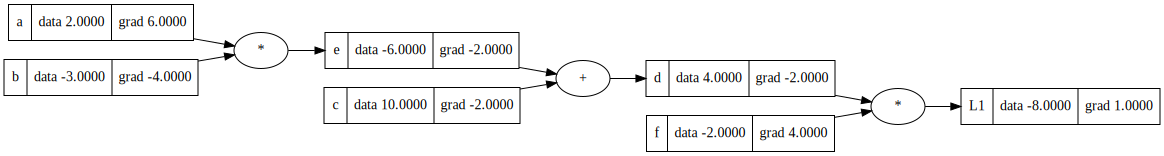

In [47]:
L.grad = 1.0

# dL/dd = ?
# def of derivative is: (f(x+h) - f(x))/ h
# function here is d*f
# ((d+h)*f - d*f) / h = df + hf - df / h = f
# derivative is f
d.grad = f.data

# symetrically dL/df = d
f.grad = d.data

# dL/dc
# how to derive?
# we know how L is sensitive to d
# but how is L impacted if c is wiggled
# intuitively, if you know the impact c has on d, and d has on L, you can put that info together
# dd / dc = ??
# d = c + e 
# dd / dc = 1
# go to basics
# (f(x+h) - f(x)) / h
# (c+h +e) - (c+e) / h = h/h = 1
# then, symetrically 
# dd / de = 1 as well
# this is the local derivative; the answer is the chain-rule in calculus
# the chain rule tells us how to chain the derivatives together
# we apply a multiplaction of the derivatives
# if a car travels twice as fast as a bicycle and the biccyle is four times as fast as the walking man, then the car travels 2x4 times as fast as the man

# dL / dc = (dL / dd) * (dd / dc), so you multiply the gradients
c.grad = d.grad * 1 # basically you just copy over the gradient when there is a plus node. Just routes the gradient
e.grad = d.grad * 1

# dL / da = dL/dd * dd/de * de/da
# then what is dc/da?
# f(x) = a*b
# (a+h)*b - a*b / h = b, so de/da = b
# symmetrically, de/db = a
a.grad = e.grad * b.data # dL/dd * dd/de * de/da
b.grad = e.grad * a.data # dL/dd * dd/de * de/db

# so in the multiplication case, you take the parent grad multiplied by the other child gradient and multiply them

draw_dot(L)

In [ ]:
# test out the backprop algo
# L.backward(1.0)
# L._grad = 1.0
# L._op = '*'
# d.grad = -2.0
#     d._op = +
#         e.backward(-2)
# f.grad = 4.0

# for i in range(len(self._prev)): #2
#     i = 0
#         for c in [0:0] + [1:] #f
#             prod = 1.0 * f.data (-2)
#         _prev[0] = d
#         d.backward(1.0 * -2)
#     i = 1
#         for c in [0:1] + [2:] #d
#             prod = 1.0 * d.data (4.0)
#         _prev[1] = f
#         f.backward(1.0 * 4.0)
            

# backpropagate through this node and fill out gradients of children
# def backward(self, grad):
#     # depends on the op
#     # in the case of add, you just take the grad of the parent
#     self._grad = grad
#     if self._op == '+':
#         for c in self._prev:
#             c.backward(self, grad)
#     # in the case of mul, for node A, set grad to product of all other nodes multipled by grad of the parent
#     elif self._op == '*':
#         prod = 1.0
#         for i in range(len(self._prev)):
#             for c in self._prev[:i] + self._prev[i+1:]:
#                 prod *= c.data
#             self._prev[i].backward(self, grad * prod)
#     else:
#         # no op, don't differentiate
#         break

In [70]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')   
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c') 
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L1'
    L1 = L.data

    a = Value(2.0, label='a')   
    b = Value(-3.0+h, label='b')
    c = Value(10.0, label='c') 
    e = a*b; e.label = 'e'
    # e.data += h
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L2'
    L2 = L.data

    print ((L2-L1) / h)

lol()

for i in range(2):
    print(i)

a = [0,1,2,3,4,5]
aset = set(a)
for i in range(len(a)):
    print(a[:i]+a[i+1:])

aset
for c in aset:
    cset = set([c])
    print(aset - cset)

-3.9999999999995595
0
1
[1, 2, 3, 4, 5]
[0, 2, 3, 4, 5]
[0, 1, 3, 4, 5]
[0, 1, 2, 4, 5]
[0, 1, 2, 3, 5]
[0, 1, 2, 3, 4]
{1, 2, 3, 4, 5}
{0, 2, 3, 4, 5}
{0, 1, 3, 4, 5}
{0, 1, 2, 4, 5}
{0, 1, 2, 3, 5}
{0, 1, 2, 3, 4}


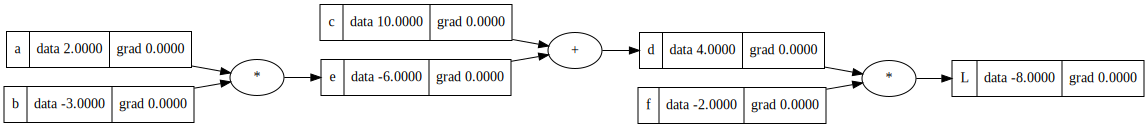

In [73]:
draw_dot(L)

In [81]:
# try backprop
L.backward(1.0)

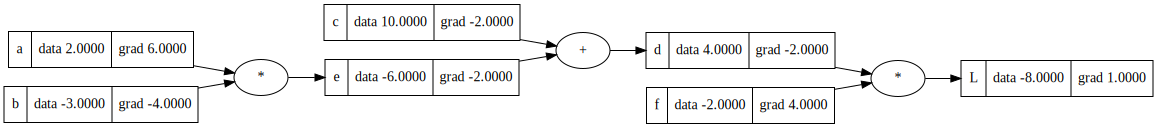

In [82]:
draw_dot(L)

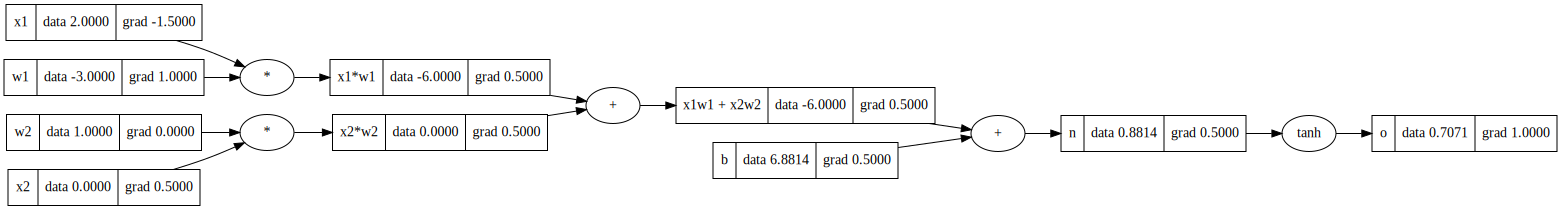

In [376]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
# before calling backward you need to zero out the gradients

o.backward(1.0)
draw_dot(o)

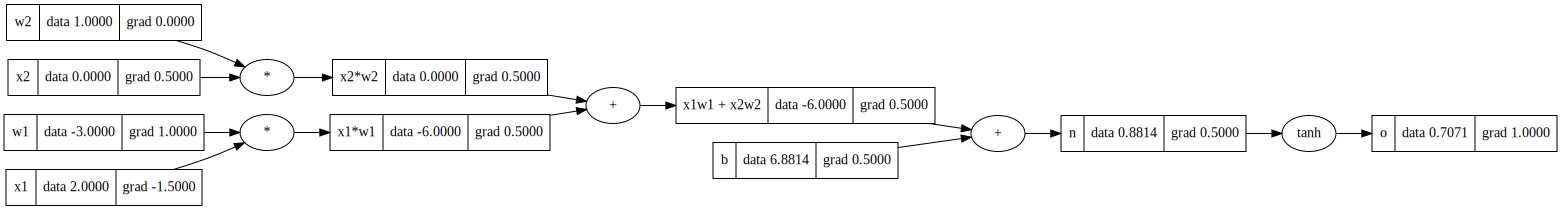

In [115]:
# manual backpropagation

# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = o**2

o.data
o.data**2

o.grad = 1.0
n.grad = o.data**2

x1w1x2w2.grad = n.grad
b.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad 
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

draw_dot(o)

In [126]:
a = Value(1.0)
a + -1
-1 + a

a * 2
2 * a

a * (1/2)

Value(data=0.5)

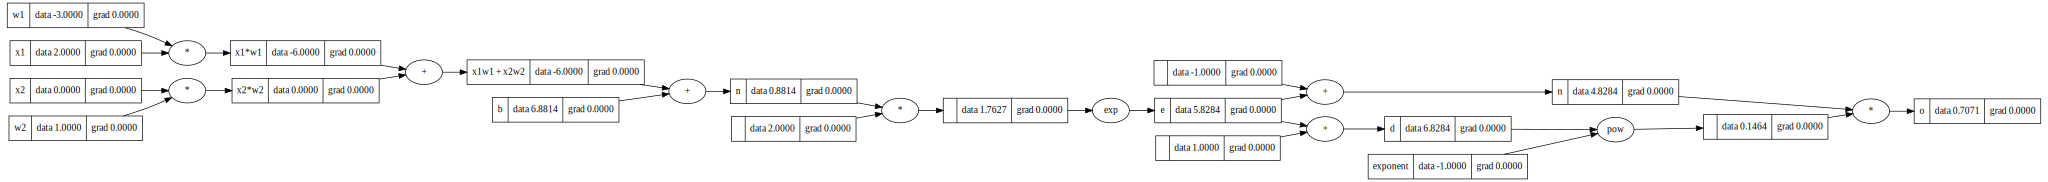

In [246]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# o = n.tanh(); o.label = 'o'
# replace tanh with exp, should get same gradients
# tanh = (e**2x - 1) / (e**2x + 1)
e = (2*n).exp(); e.label = 'e'
numerator = e - 1; numerator.label = 'n'
denominator = e + 1; denominator.label = 'd'
# o = numerator * (denominator.pow(Value(-1))); o.label='o'
o = numerator / denominator; o.label='o'

# before calling backward you need to zero out the gradients

draw_dot(o)

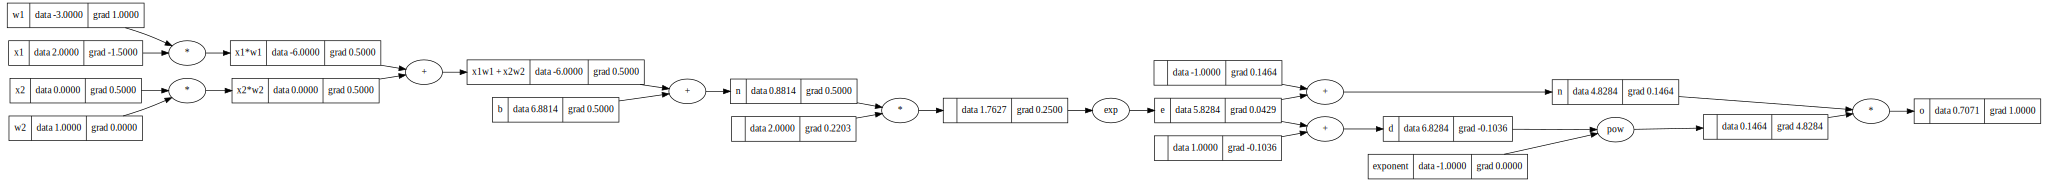

In [247]:
o.backward(1.0)
draw_dot(o)

# a = 1
# b = 2
# c = set((a,b))

# c.difference([b])

# for i in c:
#     print(i) 



In [ ]:
# what should the gradient be?
# x = .8814
# n: e**2x-1; n' = e**2x;   f: e**x; f'=e**x * grad
# d: e**2x+1

In [248]:
import torch

In [252]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad=True
b = torch.Tensor([6.8813735870185432]).double(); b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
# print('x2', x2.grad.item())

---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [360]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w*x+b
        # print(list(zip(self.w,x))) # takes two iteratives and creates a new iterator that iterates over tuples
        act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range((len(nouts)))]

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
def loss(ys, ypred):
    return sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])


In [355]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [371]:
# reset
mlp = MLP(3,[4,4,1])

# zero gradients
for p in mlp.parameters():
    p.grad = 0


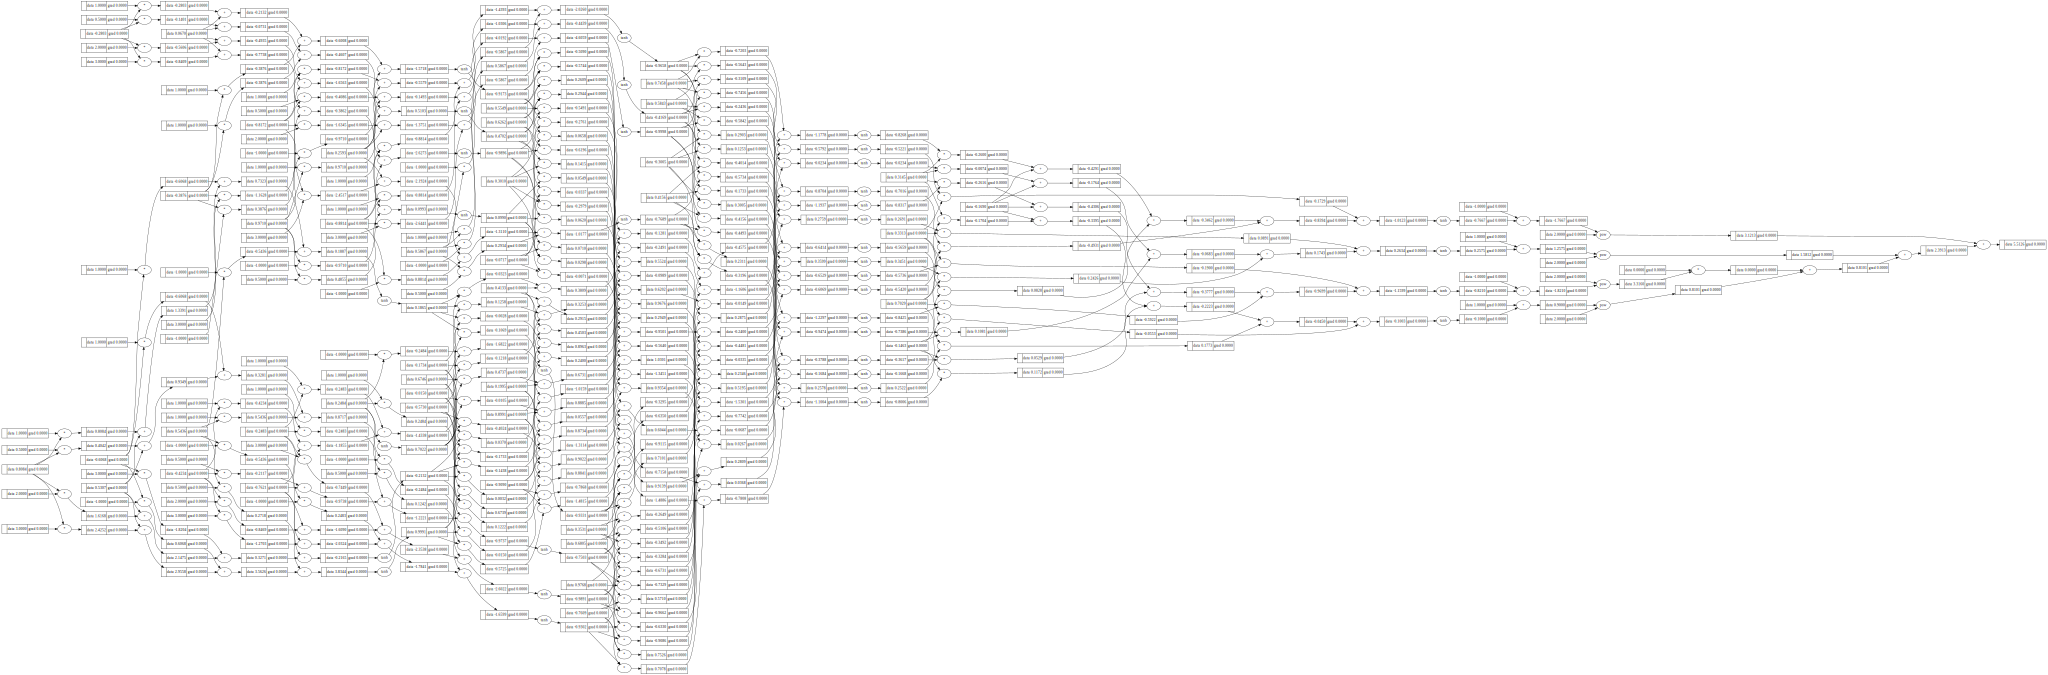

In [372]:
ypred = [mlp(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
draw_dot(loss)

In [373]:
print(f'initial loss: {loss.data}')

for i in range(10):# forward pass
    # zero gradients
    for p in mlp.parameters():
        p.grad = 0
        
    ypred = [mlp(x) for x in xs]

    # compute loss 
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    print(f'[{i}] loss: {loss}')
    loss.backward(1.0)

    # backpropagation
    lr = 0.01
    for p in mlp.parameters():
        p.data += -lr * p.grad

initial loss: 5.512599293960063
[0] loss: Value(data=5.512599293960063)
[1] loss: Value(data=4.168776543397852)
[2] loss: Value(data=3.755782793296939)
[3] loss: Value(data=3.762692383720395)
[4] loss: Value(data=3.8258017795047574)
[5] loss: Value(data=3.8899518874799943)
[6] loss: Value(data=3.9322013045797584)
[7] loss: Value(data=4.240086610605378)


OverflowError: math range error

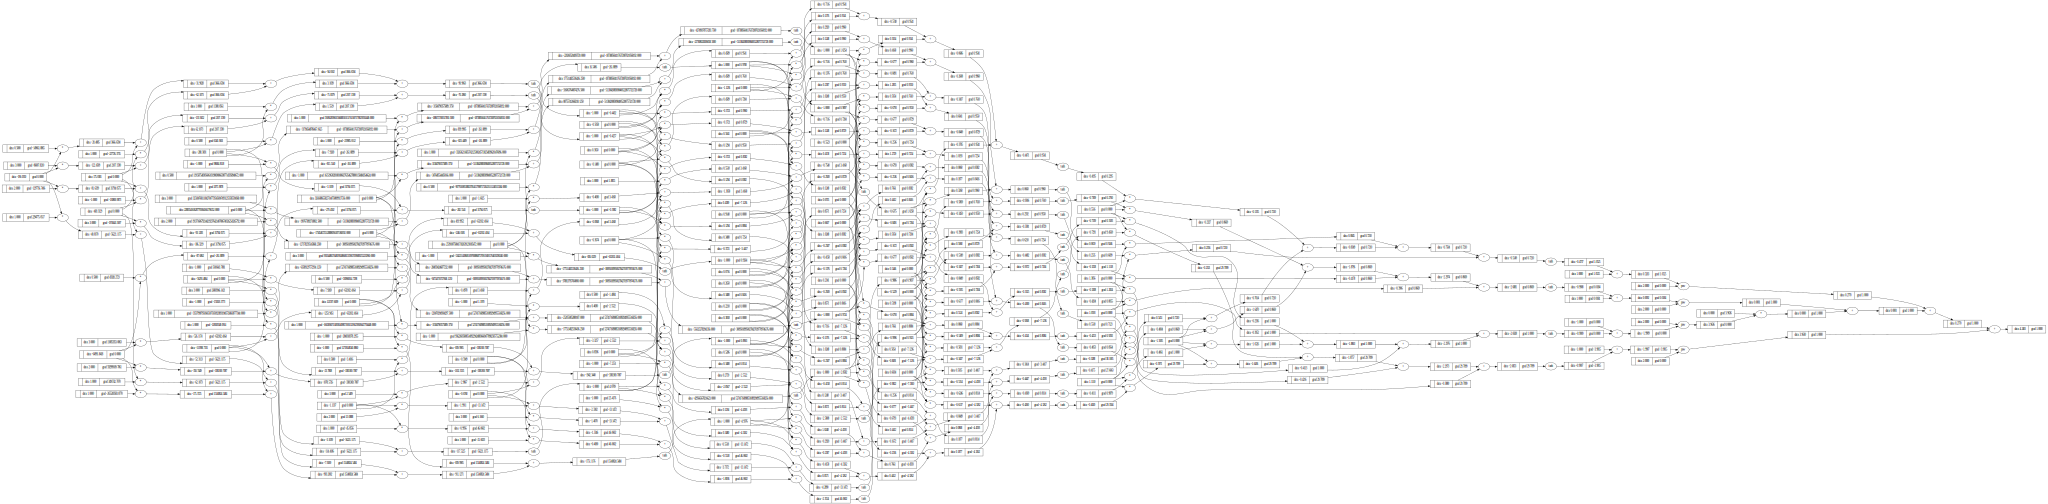

In [374]:

draw_dot(loss)

In [315]:
print(mlp.layers[0].neurons[0].w[0].grad)
print(mlp.layers[0].neurons[0].w[0].data)


-192.92261106222725
-18.30679928730993


In [316]:
print(mlp.layers[0].neurons[0].w[0].grad)
print(mlp.layers[0].neurons[0].w[0].data)

-192.92261106222725
-16.377573176687655


In [301]:
mlp.layers[0].neurons[0].w[0].grad

# nudge everything based on grad info


33.72368089489569